In [1]:
import re
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint

import pandas as pd
import json



In [2]:
cn_model = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram',
                                            binary=False, unicode_errors='ignore')


In [3]:
x = []
y = []
with open("category_data",'r',encoding='utf-8') as f:
    data = json.load(f)
for item in data:
    x.append(item['content'])
    y.append(item['label'])
print(len(x))

34730


In [4]:
x_tokens = []

for text in x:
    # 使用jieba进行分词
    cut = jieba.cut(text)
    cut_list = [i for i in cut]
    for i,word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    x_tokens.append(cut_list)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.604 seconds.
Prefix dict has been built successfully.


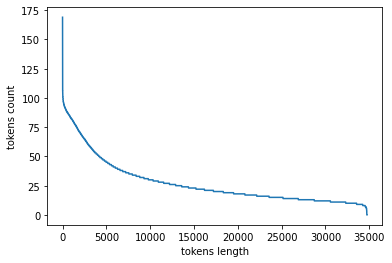

75.0


In [6]:
tokens_count = [len(tokens) for tokens in x_tokens]
tokens_count.sort(reverse=True)
# 画图查看词的长度分布
plt.plot(tokens_count)
plt.ylabel('tokens count')
plt.xlabel('tokens length')
plt.show()

#长度分布不均匀，自己确定长度为75
tokens_length = np.float64(75)
print(tokens_length)

In [10]:
#75的长度可以覆盖超过95%的样本
np.sum(tokens_count < tokens_length) / len(tokens_count)


0.9525770227469047

In [7]:
embedding_matrix = np.zeros((50000, 300))
for i in range(50000):
    embedding_matrix[i, :] = cn_model[cn_model.index_to_key[i]]
embedding_matrix = embedding_matrix.astype('float32')

300


In [8]:
x_tokens_pad = tf.keras.preprocessing.sequence.pad_sequences(x_tokens,
                                                                  maxlen=int(tokens_length),
                                                                  padding='pre',
                                                                  truncating='pre')
x_tokens_pad[x_tokens_pad >= 50000] = 0

print(len(x_tokens_pad[103]))
print(x_tokens_pad[103])


75
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    1 1166   11  758    0   83
  418  292    3    0    3]


In [9]:
encoder = preprocessing.LabelEncoder()

y_tokens = encoder.fit_transform(y)
y_tokens = tf.keras.utils.to_categorical(y_tokens)

print(y_tokens)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [10]:
x_tokens_train, x_tokens_test, y_tokens_train, y_tokens_test = train_test_split(
    x_tokens_pad,
    y_tokens,
    test_size=0.1,
    random_state=12
)

In [11]:
save_dir = os.path.join(os.getcwd(), 'saved_models/category_4')
filepath="model_{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath), monitor='val_accuracy',verbose=1, 
                            save_best_only=True)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000,300,
                                         weights=[embedding_matrix],
                                         input_length=int(tokens_length),
                                         trainable=False                                        
                                        ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=96, return_sequences=True)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

In [14]:
history = model.fit(x_tokens_train, 
          y_tokens_train,
          batch_size=128,
          epochs=20, 
          validation_split=0.1,
          validation_freq=1,
          callbacks=[checkpoint]
         )

Epoch 1/20
220/220 [==============================] - 34s 155ms/step - loss: 0.4816 - accuracy: 0.8428 - val_loss: 0.9781 - val_accuracy: 0.7127

Epoch 00001: val_accuracy did not improve from 0.72169
Epoch 2/20
220/220 [==============================] - 34s 155ms/step - loss: 0.4384 - accuracy: 0.8605 - val_loss: 1.0273 - val_accuracy: 0.7153

Epoch 00002: val_accuracy did not improve from 0.72169
Epoch 3/20
220/220 [==============================] - 34s 157ms/step - loss: 0.3943 - accuracy: 0.8757 - val_loss: 1.1955 - val_accuracy: 0.7127

Epoch 00003: val_accuracy did not improve from 0.72169
Epoch 4/20
220/220 [==============================] - 35s 158ms/step - loss: 0.3628 - accuracy: 0.8837 - val_loss: 1.2802 - val_accuracy: 0.7063

Epoch 00004: val_accuracy did not improve from 0.72169
Epoch 5/20
220/220 [==============================] - 35s 159ms/step - loss: 0.3330 - accuracy: 0.8958 - val_loss: 1.2824 - val_accuracy: 0.7054

Epoch 00005: val_accuracy did not improve from 0.7

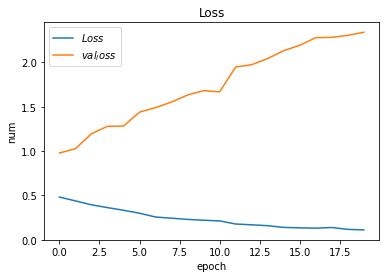

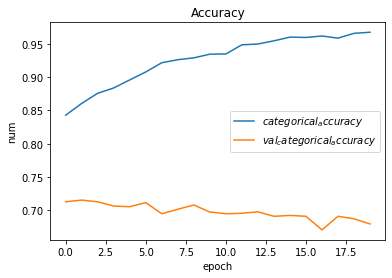

In [16]:
plt.plot(history.history['loss'],label="$Loss$")
plt.plot(history.history['val_loss'],label='$val_loss$')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label="$categorical_accuracy$")
plt.plot(history.history['val_accuracy'],label='$val_categorical_accuracy$')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()

In [19]:
result = model.evaluate(x_tokens_test, y_tokens_test)
print(f'Accuracy : {result[1]}')

109/109 [==============================] - 4s 26ms/step - loss: 0.8847 - accuracy: 0.7198
Accuracy : 0.7198387384414673


In [141]:

#测试模型

def predict_sentiment(text):
    print(text)
    cut = jieba.cut(text)
    cut_list = [x for x in cut]
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.key_to_index[word]
        except KeyError:
            cut_list[i] = 0
        pass
    # padding
    tokens_pad = tf.keras.preprocessing.sequence.pad_sequences([cut_list],
                                                                  maxlen=int(tokens_length),
                                                                  padding='pre',
                                                                  truncating='pre')
    # 大于50000的归0，不归0模型的使用会报错
    tokens_pad[tokens_pad >= 50000] = 0
    return tokens_pad
test_list = [
#输入想要测试的语句
]
for text in test_list:
    try:
        tokens_pad = predict_sentiment(text)
        result = model.predict(x=tokens_pad)
        print(encoder.inverse_transform([0,1,2,3,4,5]))
        print(result)
       
    except Exception as ex:
        print(ex.args)
        pass
    pass

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 75, 300)           15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 192)           304896    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13376     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 96)                1632      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 5